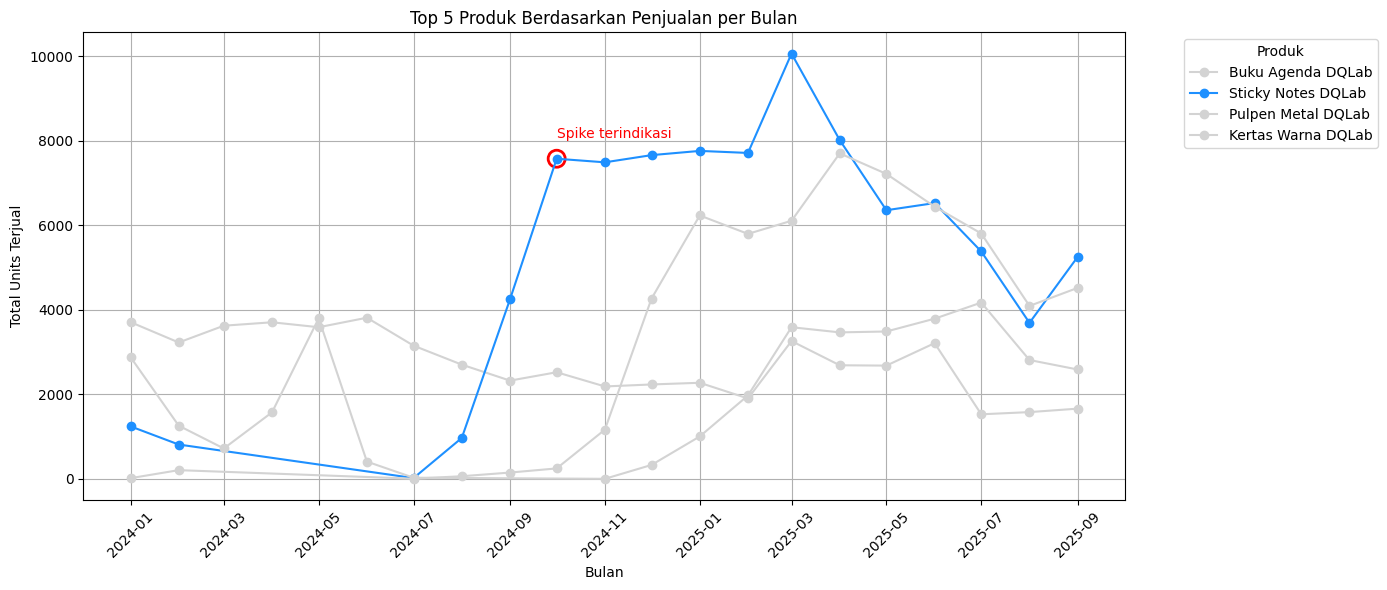

In [1]:
#SALES SPIKE

# Import library
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Membaca dataset dari file csv
df_transaction = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/tbl_transaction.csv')
df_product = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/tbl_product.csv')

# Menggabungkan dua dataset
df_merged = pd.merge(df_transaction, df_product, on = 'product_id', how = 'left')

# Merapikan format tanggal dan units
df_merged['trx_date'] = pd.to_datetime(df_merged['trx_date'].astype(str), format = '%d%m%Y', errors = 'coerce')
df_merged['units'] = df_merged['units'].fillna(0).astype(int)

# Menghapus nilai kosong dan duplikat
df_merged = df_merged.dropna().drop_duplicates()

# Membuat kolom bulan (periode)
df_merged['trx_month'] = df_merged['trx_date'].dt.to_period('M').dt.to_timestamp()

# Agregasi penjualan per produk per bulan
df_sales_summary = df_merged.groupby(['trx_month', 'product_id', 'product_name'])['units'].sum().reset_index()

# Mengambil 5 produk dengan total units terbanyak
top_products = df_sales_summary.groupby ('product_name')['units'].sum().nlargest(5).index

# Filter hanya untuk 5 produk tersebut
df_top_sales = df_sales_summary[df_sales_summary['product_name'].isin(top_products)].copy()

# Plotting dengan fitur tambahan
plt.figure(figsize=(14, 6))

# Produk target yang akan disorot
target_product = 'Sticky Notes DQLab'

# Warna: produk target tetap cerah, lainnya redup
colors = {
    name: 'dodgerblue' if name == target_product else 'lightgray' for name in df_top_sales['product_name'].unique()
}

# Gambar lineplot tiap produk
for product_name in df_top_sales['product_name'].unique():
    data = df_top_sales[df_top_sales['product_name'] == product_name]
    plt.plot(data['trx_month'], data['units'], label = product_name,
             marker='o', color=colors[product_name])

# Tambahkan lingkaran penanda spike untuk Sticky Notes DQLab di bulan ke-10
data_sticky = df_top_sales[df_top_sales['product_name'] == target_product]
data_sticky = data_sticky.sort_values('trx_month').reset_index(drop = True)

# Asumsikan spike pada bulan ke-10 (indeks ke-5)
if len(data_sticky) >= 10:
    spike_month = data_sticky.loc[5, 'trx_month']
    spike_units = data_sticky.loc[5, 'units']
    plt.scatter(spike_month, spike_units, s = 150, facecolors = 'none',
                edgecolors = 'red', linewidths = 2)
    plt.text(spike_month, spike_units + 500, 'Spike terindikasi', color='red')

# Penataan plot
plt.title('Top 5 Produk Berdasarkan Penjualan per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Total Units Terjual')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Produk', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.tight_layout()
plt.show()


/tmp/ipython-input-2836290340.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 35, ha = 'right')
/tmp/ipython-input-2836290340.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=35, ha = 'right')


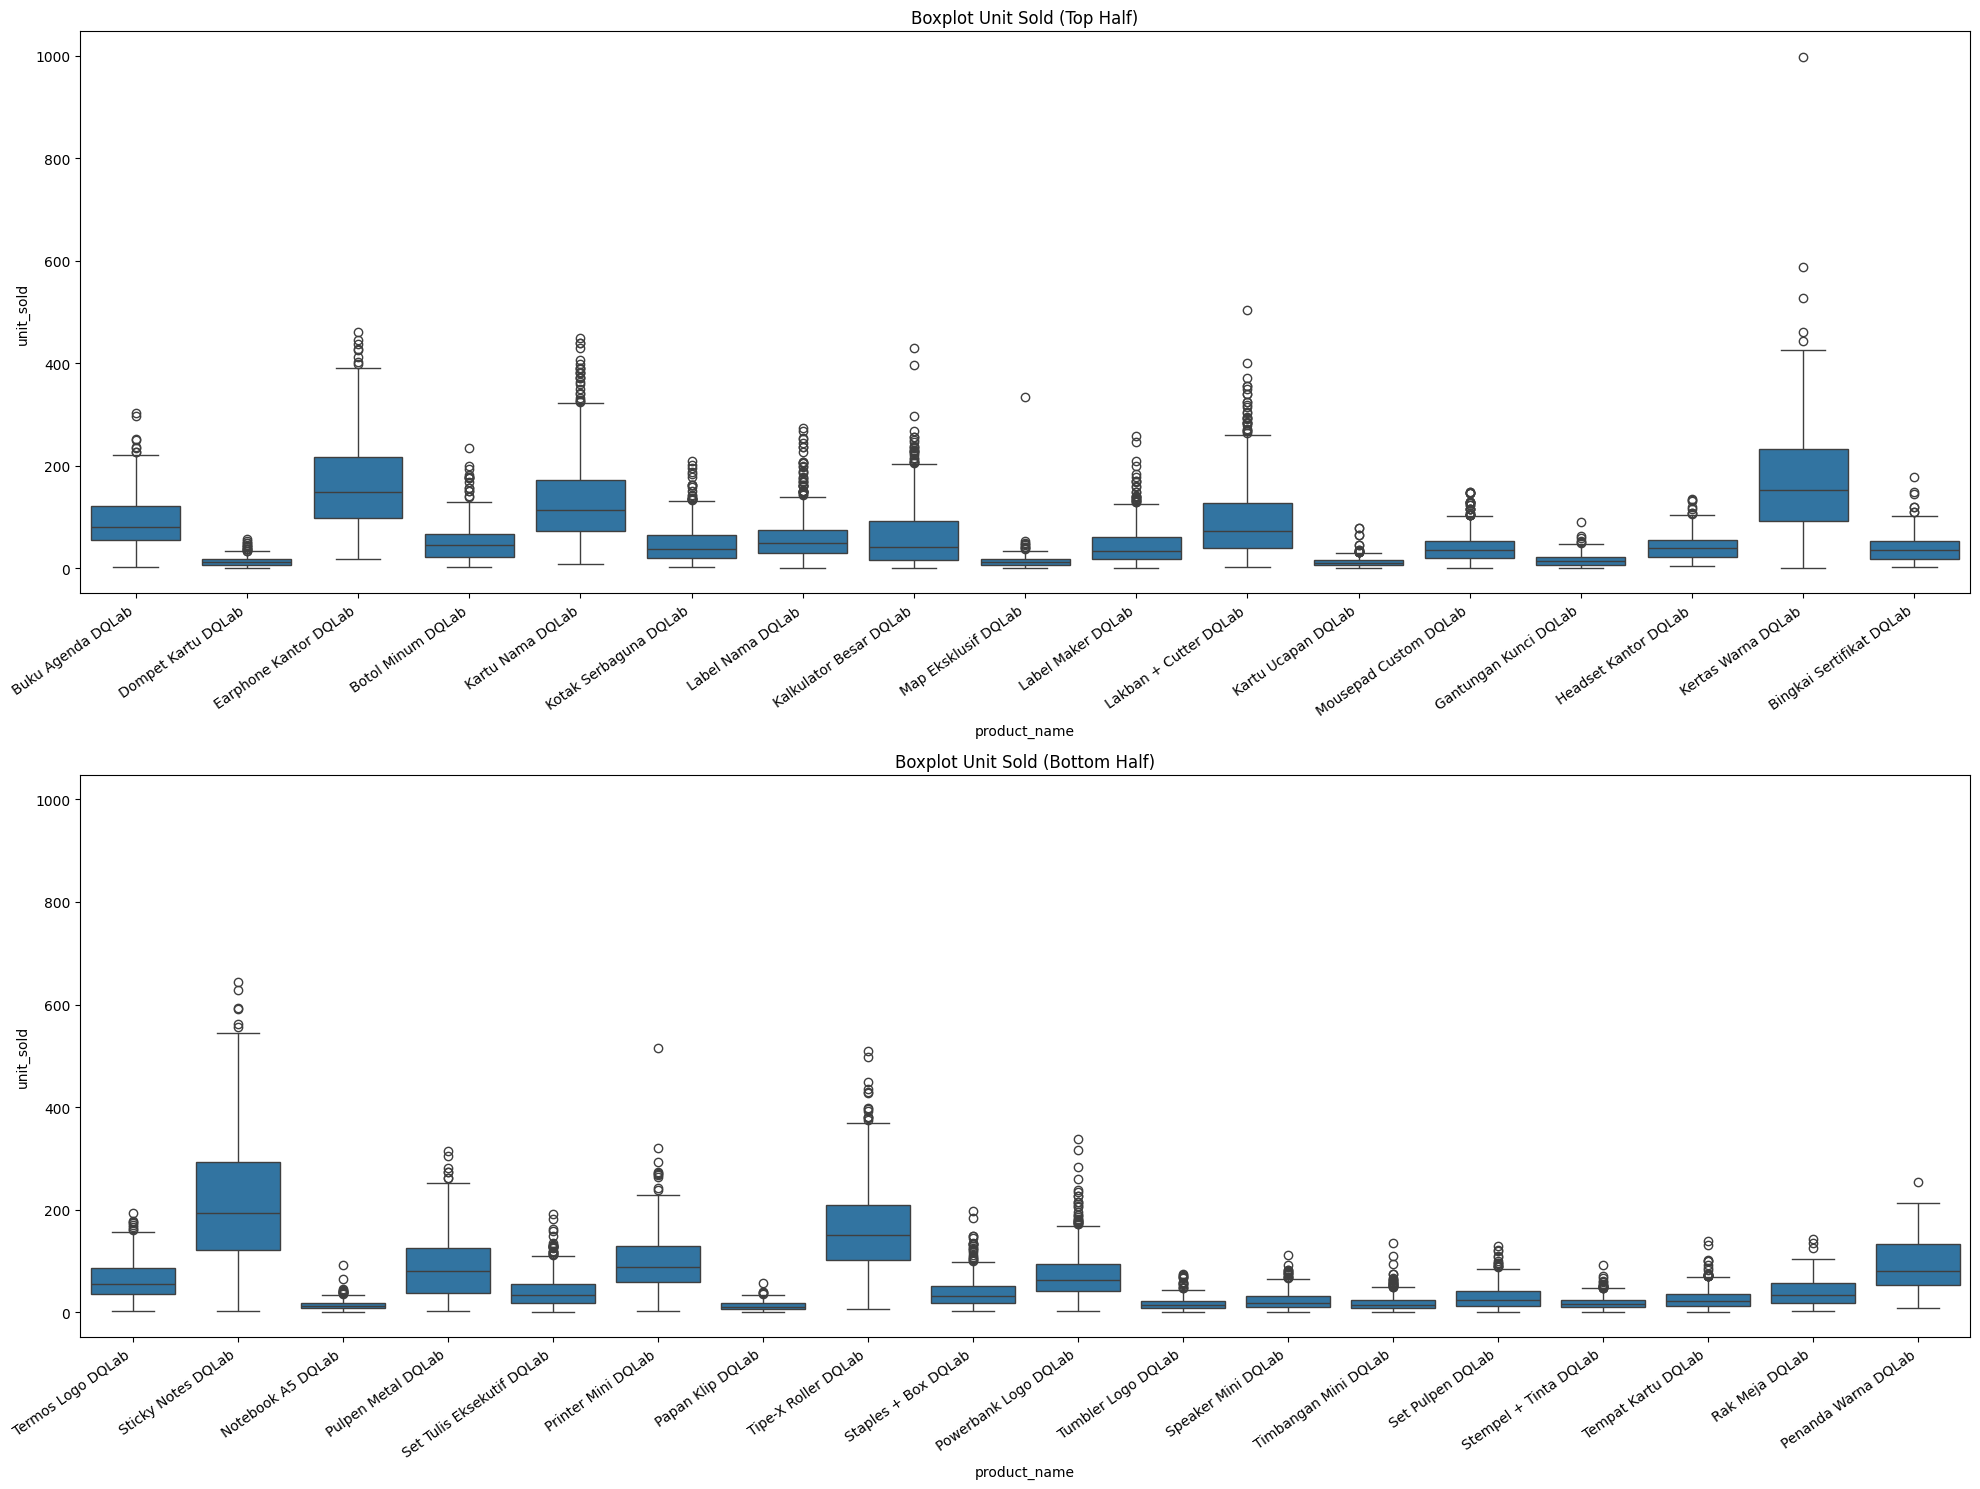

In [ ]:
# DETEKSI OUTLIER

#Membaca library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Membaca dataset
df_merged = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/stock.csv')

# Ambil daftar unik product_name dan bagi dua
product_names = sorted(df_merged['product_name'].unique())
midpoint = len(product_names) // 2
top_half = product_names[:midpoint]
bottom_half = product_names[midpoint:]

# Filter data untuk masing-masing grup
df_top = df_merged[df_merged['product_name'].isin(top_half)]
df_bottom = df_merged[df_merged['product_name'].isin(bottom_half)]

# Membuat dua subplot vertikal
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 15), sharey = True)

# Boxplot untuk setengah pertama
sns.boxplot(data = df_top, x = 'product_name', y = 'unit_sold', ax = ax1)
ax1.set_title('Boxplot Unit Sold (Top Half)')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 35, ha = 'right')

# Boxplot untuk setengah kedua
sns.boxplot(data = df_bottom, x = 'product_name', y = 'unit_sold', ax = ax2)
ax2.set_title('Boxplot Unit Sold (Bottom Half)')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=35, ha = 'right')

# Rapi
plt.tight_layout()
plt.show()


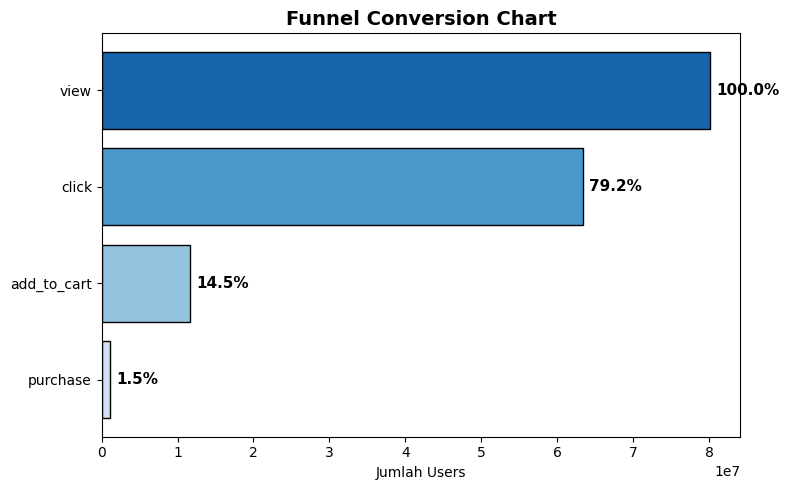

In [ ]:
#FUNNEL ANALYSIS

#Import Library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Membaca dataset
df_funnel = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/tbl_funnel.csv')
df_product = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/tbl_product.csv')

# Menggabungkan dua dataset
df_merged = pd.merge(df_funnel, df_product, on='product_id', how='left')

# Hitung total users di setiap tahap funnel
total_funnel = df_merged[['view', 'click', 'add_to_cart', 'purchase']].sum()

# Urutkan tahap dari atas ke bawah funnel
stages = total_funnel.index.tolist()
values = total_funnel.values.tolist()

# Warna gradasi
colors = sns.color_palette("Blues", len(stages))[::-1]

plt.figure(figsize=(8, 5))
for i, (stage, value) in enumerate(zip(stages, values)):
	plt.barh(stage, value, color=colors[i], edgecolor="black")

	# Hitung persentase dari tahap awal
	percent = f"{value/values[0]*100:.1f}%"

	# Teks di luar bar (kanan)
	plt.text(value + max(values)*0.01, i, percent, va='center', ha='left',
             color='black', fontsize=11, fontweight='bold')

plt.gca().invert_yaxis()
plt.title("Funnel Conversion Chart", fontsize=14, fontweight='bold')
plt.xlabel("Jumlah Users")
plt.tight_layout()
plt.show()

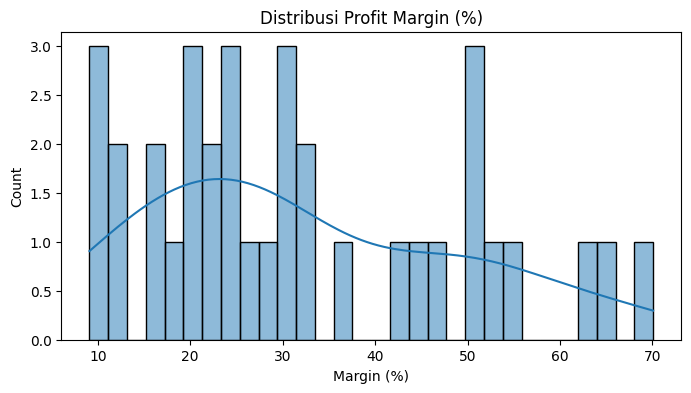

In [ ]:
#DISTRIBUSI MARGIN

#Import Library
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#Load data
df = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/stock.csv')

#Hitung margin terlebih dahulu
df['margin'] = round(((df['price']-df['cost'])/df['price'])*100, 2)

#Kelompokkan berdasarkan product_name dan hitung rata-rata margin
df = df.groupby('product_name', as_index = False).agg({
    'margin': 'mean',
    'price': 'mean',
    'cost': 'mean',
    'stock_available': 'sum'
})

#Urutkan berdasarkan margin terbesar
df = df.sort_values(by = 'margin', ascending = False)

#Buat kategori margin
def margin_category(margin):
    if margin >= 40 :
        return 'High'
    elif margin >= 20:
        return 'Medium'
    else:
        return 'Low'

df['margin_category'] = df['margin'].apply(margin_category)

# Visualisasi distribusi margin
plt.figure(figsize = (8, 4))
sns.histplot(df['margin'], bins = 30, kde = True)
plt.title('Distribusi Profit Margin (%)')
plt.xlabel('Margin (%)')
plt.show()


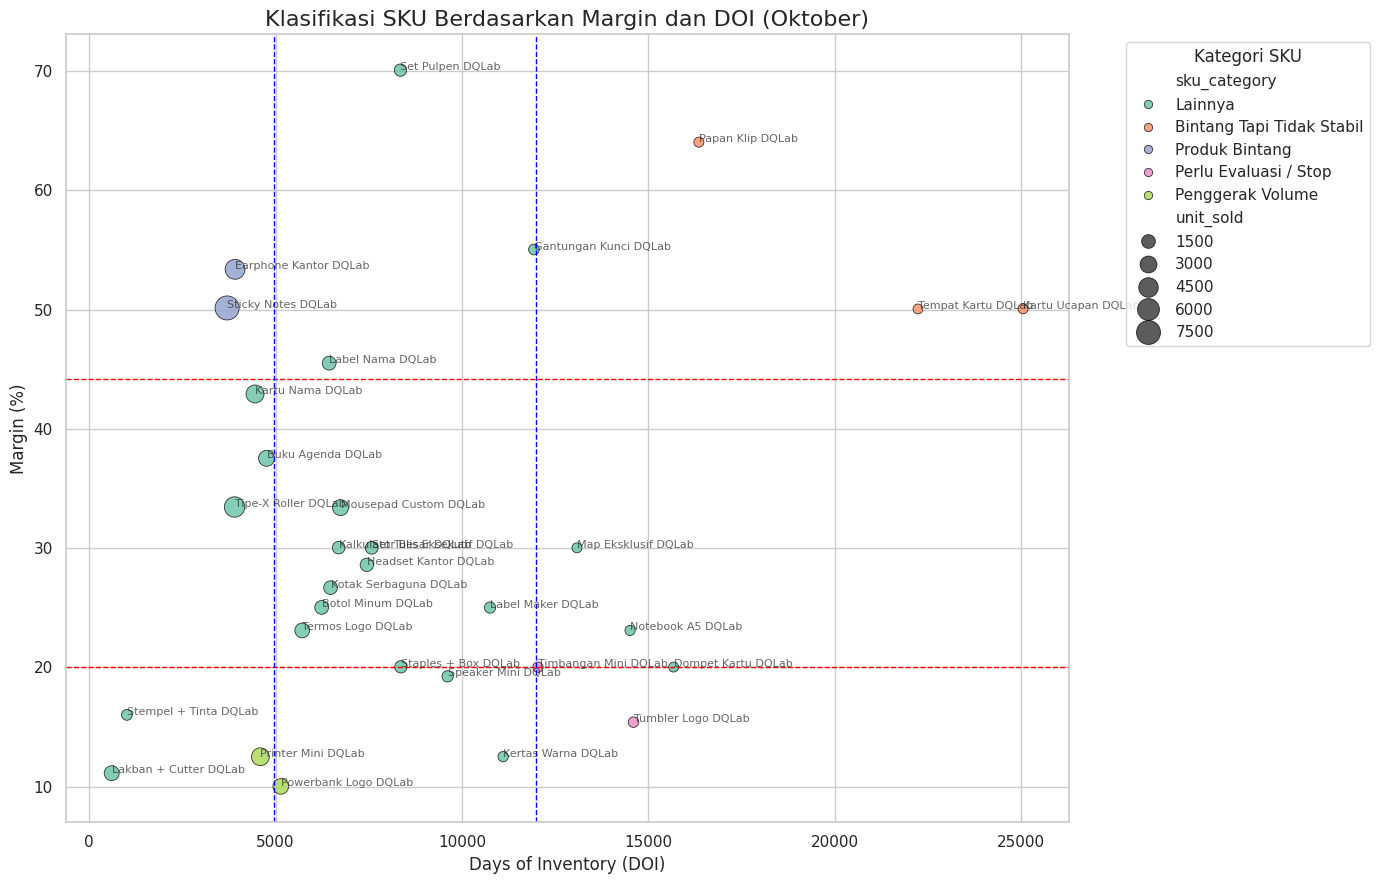

In [ ]:
# KLASIFIKASI SKU BERDASARKAN MARGIN

# Import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/margin_doi.csv')

# ======== VISUALISASI ========= #
sns.set(style="whitegrid")
plt.figure(figsize=(14, 9))

# Scatter plot
scatter = sns.scatterplot(
    data = df,
    x = 'doi',
    y = 'margin',
    hue = 'sku_category',
    size = 'unit_sold',
    sizes = (50, 300),
    palette = 'Set2',
    alpha = 0.8,
    edgecolor = 'black'
)
# Hitung kuartil
margin_q = df['margin'].quantile([0.25, 0.5, 0.75])
doi_q = df['doi'].quantile([0.25, 0.5, 0.75])

# Garis kuartil
plt.axhline(margin_q[0.75], color = 'red', linestyle = '--', linewidth = 1)
plt.axhline(margin_q[0.25], color = 'red', linestyle = '--', linewidth = 1)
plt.axvline(doi_q[0.75], color = 'blue', linestyle = '--', linewidth = 1)
plt.axvline(doi_q[0.25], color = 'blue', linestyle = '--', linewidth=1)

# Tambahkan label nama produk di setiap titik
for i, row in df.iterrows():
    if not pd.isna(row['doi']) and not pd.isna(row['margin']):
        plt.text(row['doi'] + 1, row['margin'], row['product_name'],
                 fontsize = 8, alpha = 0.7)

# Label dan layout
plt.title('Klasifikasi SKU Berdasarkan Margin dan DOI (Oktober)', fontsize = 16)
plt.xlabel('Days of Inventory (DOI)')
plt.ylabel('Margin (%)')
plt.legend(title = 'Kategori SKU', bbox_to_anchor=(1.05, 1), loc = 'upper left')
plt.tight_layout()

# Tampilkan
plt.show()
